### Kaggle Housing Price Competition

- [Run in Google Colab](https://colab.research.google.com/github/druce/iowa/blob/master/iowa)
- [Competition leaderboard](https://www.kaggle.com/c/home-data-for-ml-course/leaderboard)
- [Data set discussion](http://jse.amstat.org/v19n3/decock.pdf)
- [Data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
from itertools import product
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

# not used
def mytransform():
    return QuantileTransformer(output_distribution='normal')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#!conda install -y -c districtdatalabs yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())



2019-05-29 09:25:36.657601


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu

### 1. Import

In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial exploration

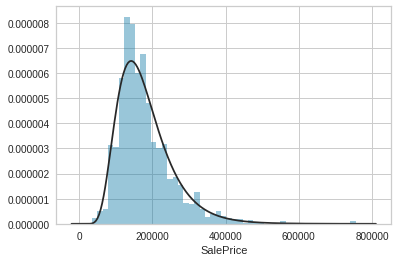

In [3]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


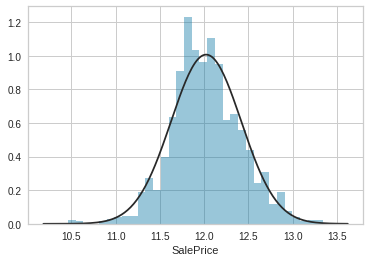

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


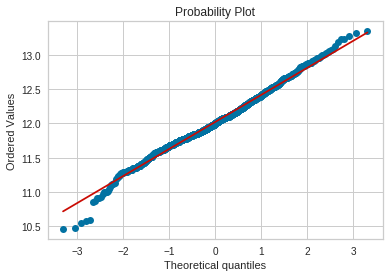

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [6]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

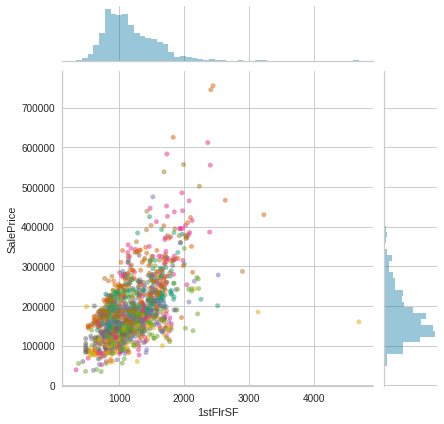

In [7]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z[colorby].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )

do_refresh()
    


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

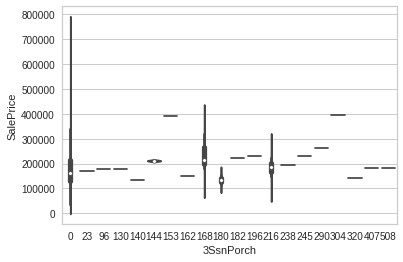

In [8]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [9]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [10]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)

(2919, 80)


### 2. Scrub

In [11]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [12]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)

(2919, 80)
23
23
34
(2919, 80)


In [13]:
df_raw.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,IR1,AllPub,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


In [14]:
df_raw[['PoolQC','MiscFeature','Alley']].count()

PoolQC          10
MiscFeature    105
Alley          198
dtype: int64

In [15]:
# drop columns with lots of missing data
# df_raw.drop(columns=['PoolQC','MiscFeature','Alley'], inplace=True)
# no variation:
df_raw.drop(columns=['Utilities'], inplace=True)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
Street           2919 non-null object
Alley            198 non-null object
LandContour      2919 non-null object
LotConfig        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
MasVnrType       2895 non-null object
Foundation       2919 non-null object
Heating          2919 non-null object
CentralAir       2919 non-null object
GarageType       2762 non-null object
MiscFeature      105 non-null object
SaleType         2918 non-null object
SaleCondition    2919 non-null object
LotShape         2919 

In [16]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [17]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

qdict = {
    'Po' : '0',
    'Fa' : '1',
    'TA' : '2',
    'Gd' : '3',
    'Ex' : '4',
    np.nan : '2'
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())

ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [18]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())

Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [19]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())

Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [20]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [21]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [22]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())



Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [23]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [24]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [25]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [26]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [27]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [28]:
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)

In [29]:
df.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,0,0,7,5,3,2,3,2,1,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,0,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,1,Attchd,NaN,WD,Normal,0,0,6,8,2,2,3,2,4,5,1,4,4,2,4,2,2,2,2,2,NaN,0,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,0,7,5,3,2,3,2,2,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,5,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,1,Detchd,NaN,WD,Abnorml,1,0,7,5,2,2,2,3,1,5,1,3,4,3,4,3,1,2,2,2,NaN,0,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,0,8,5,3,2,3,2,3,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


#### Impute / fill NAs

In [30]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

for col in ['GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


GarageArea
GarageCars
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageType


In [31]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
B

In [32]:
df.loc[df['MSSubClass'] == 150]

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2819,150,RL,Pave,NaN,HLS,Inside,ClearCr,Norm,Norm,Twnhs,4,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,1,Basment,NaN,WD,Normal,0,0,7,5,3,2,3,2,2,6,1,2,4,3,4,2,3,3,2,2,NaN,0,1980,1981,1,0,2,1,2,1,7,0,1980,1,4,2006,NaN,1700,0.0,397.0,0.0,33.0,430.0,880,680,140,1700,450.0,188,36,0,0,200,0,0,NaN


In [33]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

,MSSubClass,SalePrice
1,30,95829.724638
14,180,102300.000000
3,45,108591.666667
15,190,129613.333333
10,90,133541.076923
13,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


,MSSubClass,SalePrice
12,150,0
2,40,4
14,180,10
3,45,12
7,75,16
9,85,20
15,190,30
10,90,52
8,80,58
6,70,60


In [34]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [35]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [36]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)

Alley missing 2717
Grvl    120
Pave     78
Name: Alley, dtype: int64
Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
CBlock        2
AsphShn       2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
MiscFeature missing 2810
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw 

In [37]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')

In [38]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Grvl': 0, 'Pave': 1, 'None': 2, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'

#### Roll up rare categorical values

In [39]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [40]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


LandContour
0     115
1    2620
2      60
3     120
Name: LandContour, dtype: int64
LotConfig
0    2132
1     508
2      85
3      14
4     176
Name: LotConfig, dtype: int64
Neighborhood
0      37
1      93
2      30
3     108
4     192
5     239
6     151
7      10
8      48
9      23
10    443
11    114
12    125
13    131
14    165
15     28
16    267
17    103
18     44
19    182
20     24
21     72
22     51
23     69
24    166
Name: Neighborhood, dtype: int64
Condition1
0      92
1      28
2     163
3    2509
4      50
5       6
6       9
7      38
8      20
Name: Condition1, dtype: int64
Condition2
0       2
1       5
2      13
3       1
4    2886
5       1
6       4
7       3
Name: Condition2, dtype: int64
0 => 1
3 => 4
5 => 6
7 => 6
BldgType
0      62
1     109
2      96
3     227
4    2421
Name: BldgType, dtype: int64
RoofStyle
0      22
1    2309
2      11
3      20
4     548
5       5
Name: RoofStyle, dtype: int64
RoofMatl
0       1
1    2874
2       1
3      23
4       9
5

#### Engineer

In [41]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] > 5, 'TotalBath'] = 5
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] > 2, 'BsmtBath'] = 2

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 4, 'GarageCars'] = 4
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] > 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
#df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF '] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['KitchenQual x KitchenAbvGr'] = df['KitchenQual'] * df['KitchenAbvGr']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         


In [42]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


,monthnum,YrSold,MoSold
0,0,2006,1
1,1,2006,2
2,2,2006,3
3,3,2006,4
4,4,2006,5


,monthnum,YrSold,MoSold
50,50,2010,3
51,51,2010,4
52,52,2010,5
53,53,2010,6
54,54,2010,7


(2915, 115)
(2915, 116)


#### Transform (logs, squares)

In [43]:
# we test variables below to see if log or square has higher correlation with response and transform accordingly

transformsquare = ['BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF x BsmtQual', 'Functional x OverallQual',]

for col in transformsquare:
    print(col)
    df[col] = df[col] ** 2
    df.rename(columns={col : 'sq' + col}, inplace=True)


BsmtUnfSF
2ndFlrSF
BsmtFinSF
BsmtFinSF x BsmtQual
Functional x OverallQual


In [44]:
transformlog = ['LotArea', 'YearBuilt', 'GrLivArea', 'GarageYrBlt', 'TotalFinSF', 
                #'ExterCond' 'BsmtFinType2', 'BsmtExposure',
                'LivAreaRatio', 'BedRatio', 'GarageRatio', 'BathRatio', 'LotRatio', 
                #'OverallQualRatio','ExterQualRatio','BsmtQualRatio','GarageQualRatio',
                'TotalSF x OverallQual', 'KitchenAbvGr x KitchenQual', 
                'TotalSF x OverallCond','OverallQual x OverallCond','AvgBltRemod x OverallCond',
                'AvgBltRemod x TotalFinSF','YearBuilt x OverallCond','OverallCond x AvgBltRemod',
                'KitchenQual x KitchenAbvGr','FireplaceQu x Fireplaces',
               ]

for col in transformlog:
    print(col)
    df[col] = np.log1p(df[col])
    df.rename(columns={col : 'log' + col}, inplace=True)


LotArea
YearBuilt
GrLivArea
GarageYrBlt
TotalFinSF
LivAreaRatio
BedRatio
GarageRatio
BathRatio
LotRatio
TotalSF x OverallQual
KitchenAbvGr x KitchenQual
TotalSF x OverallCond
OverallQual x OverallCond
AvgBltRemod x OverallCond
AvgBltRemod x TotalFinSF
YearBuilt x OverallCond
OverallCond x AvgBltRemod
KitchenQual x KitchenAbvGr
FireplaceQu x Fireplaces


#### Fix highly skewed predictors

In [45]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Review and Setup

In [46]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [47]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
            'MiscVal',
            'PoolArea',
            'Street', 
           ]

df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 104)


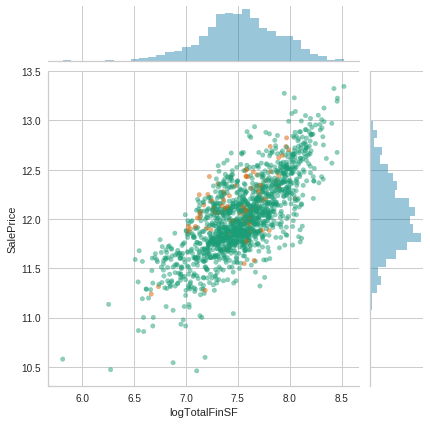

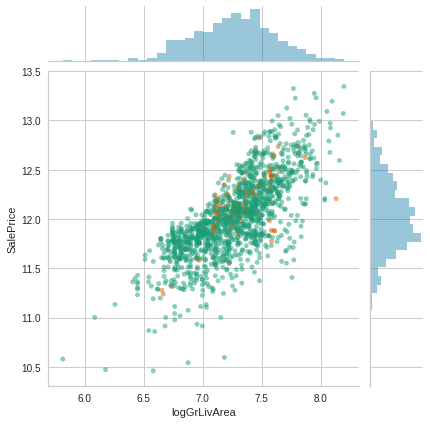

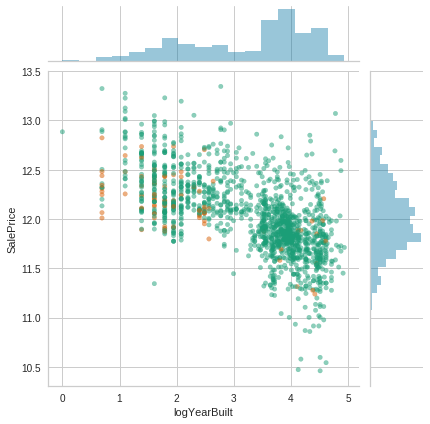

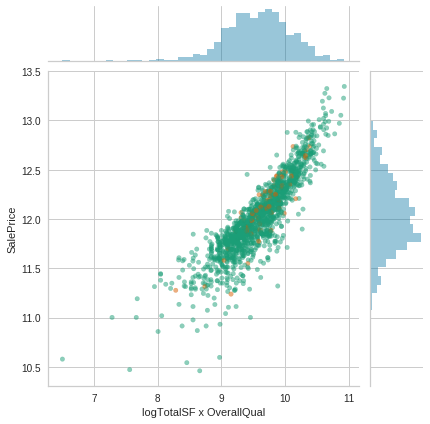

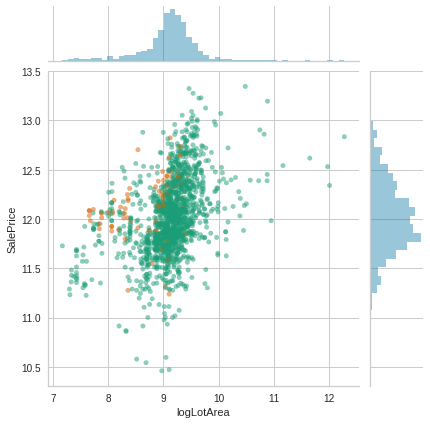

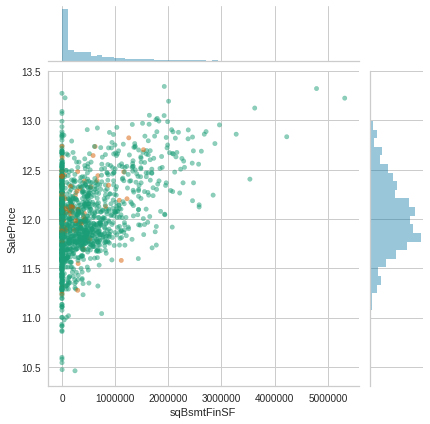

In [48]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['logTotalFinSF','logGrLivArea','logYearBuilt','logTotalSF x OverallQual','logLotArea','sqBsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    


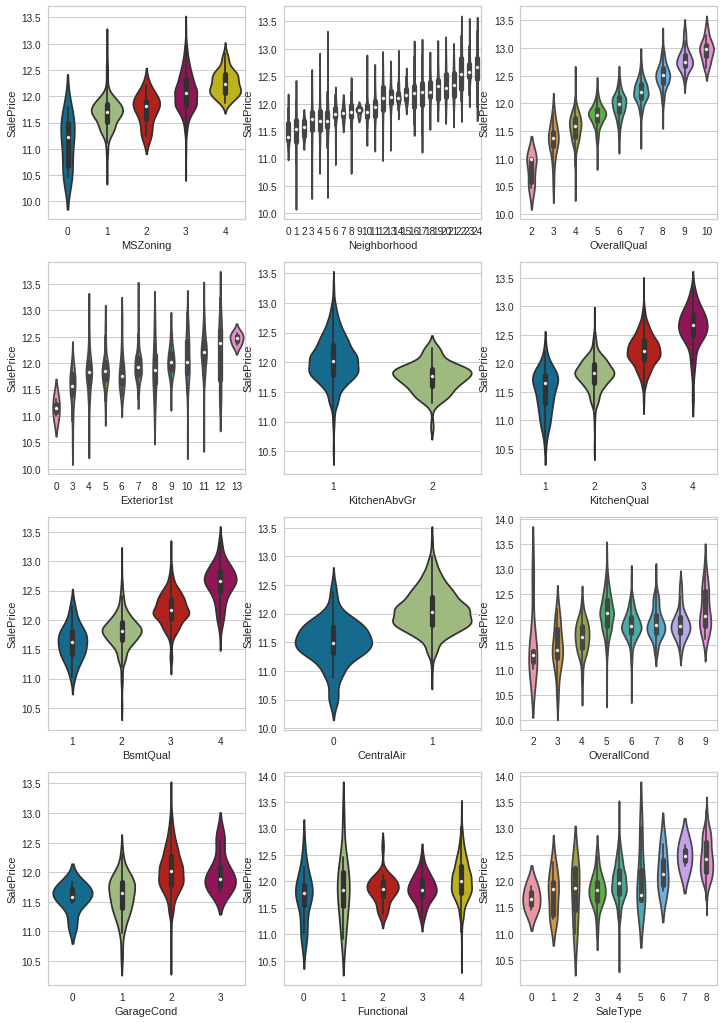

In [49]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [50]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireBathRatio', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageQual x GarageCond x GarageCars', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HeatingQC x Heating', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotRmsAbvGrd', 'TotalBath', 'has2ndfloor', 'hasfireplace', 'logFireplaceQu x Fireplaces', 'logGarageRatio', 'logKitchenAbvGr x KitchenQual', 'logKitchenQual x KitchenAbvGr', 'sqFunctional x Overal

Dropdown(description='Variable:', options=('1stFlrSF', 'AvgBltRemod', 'AvgBltRemod x Functional x TotalFinSF '…

Dropdown(description='Color by:', index=47, options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCon…

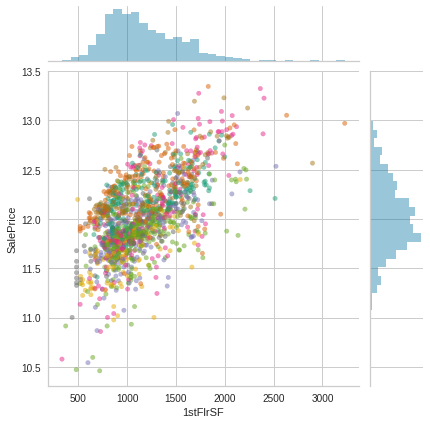

In [51]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposu…

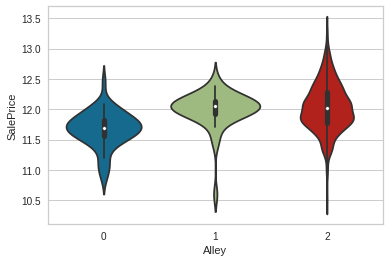

In [52]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [53]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    print(col, 'log', log, 'linear', linear, 'square', square)
    

MSSubClass log -0.0004798907734951526 linear -0.04514451690638043 square -0.09328233312170445
MSZoning log 0.41753275148485824 linear 0.41279756852904714 square 0.3968974086646346
Alley log 0.16242653532499024 linear 0.15754606824608658 square 0.1454785444063308
LandContour log 0.16278764070540458 linear 0.15709534886644297 square 0.13402513591086052
LotConfig log 0.12785450847566468 linear 0.14424571916822732 square 0.1537406785470078
Neighborhood log 0.6886270727823947 linear 0.7420311981460962 square 0.7282914789507746
Condition1 log 0.1850577692219324 linear 0.18380549468895432 square 0.14073313864977835
Condition2 log 0.10212307960484668 linear 0.10726550305334924 square 0.10860889036903383
BldgType log 0.18116649123563208 linear 0.183155943702183 square 0.17511133594202238
HouseStyle log 0.11447612264187941 linear 0.1393572946258224 square 0.1696622861142495
RoofStyle log 0.20614395906459587 linear 0.20475409957822752 square 0.2027659110664456
RoofMatl log 0.09410713890389882 lin

In [54]:
# # make these strings
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

df_nodummies = df.copy()

categorical_str = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig',
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'Foundation', 'Heating', 'CentralAir', 'GarageType', 'SaleType',
                   'SaleCondition', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                   'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical',
                   'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                   'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 
                   'Fireplaces', 'GarageCars', 'MoSold', 'monthnum']

for col in df.columns:
    cardinality = df[col].value_counts().shape[0]
    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
        print(col)
        df[col] = df[col].apply(str)

        

MSZoning
Alley
LandContour
LotConfig
Neighborhood
Condition1
Condition2
BldgType
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
GarageType
MiscFeature
SaleType
SaleCondition
LotShape
LandSlope
ExterQual
ExterCond
BsmtQual
BsmtCond
HeatingQC
Electrical
KitchenQual
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
BsmtFullBath
HalfBath
Fireplaces


In [55]:
# concatenate columns that have strong interactions
# this should be in 'engineer features'

# merge_interact_cats = [('Fireplaces','FireplaceQu'),
#                        ('KitchenAbvGr','KitchenQual'),
#                        ('GarageFinish','GarageQual'),
#                        ('RoofMatl','RoofStyle'),
#                        ('LotConfig', 'LotShape'),
#                        ('LandSlope', 'LandContour')
#                       ]

# for cat1, cat2 in merge_interact_cats:
#     print(cat1+cat2)
#     df[cat1 + "|" + cat2]=df[cat1].astype(str) + "~" + df[cat2].astype(str)
#     df.drop(columns=[cat1, cat2], inplace=True)

In [56]:
# transform categorical variables to dummies
print(df.shape)
df = pd.get_dummies(df)
#df = pd.get_dummies(df, drop_first=True)
print(df.shape)

(2915, 104)
(2915, 265)


In [57]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance

['LotConfig_3',
 'Neighborhood_7',
 'Condition1_5',
 'Condition1_6',
 'Condition2_1',
 'Condition2_2',
 'Condition2_6',
 'RoofStyle_2',
 'RoofStyle_5',
 'RoofMatl_4',
 'RoofMatl_6',
 'Exterior1st_0',
 'Exterior1st_13',
 'Exterior2nd_12',
 'Exterior2nd_7',
 'Foundation_3',
 'Foundation_4',
 'Heating_1',
 'Heating_2',
 'GarageType_1',
 'MiscFeature_0',
 'MiscFeature_2',
 'MiscFeature_4',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleCondition_0',
 'LandSlope_2',
 'ExterCond_4',
 'Electrical_0',
 'GarageCond_0',
 'PoolQC_0',
 'PoolQC_1',
 'PoolQC_2',
 'PoolQC_3',
 'Fireplaces_3']

In [58]:
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)

Exterior1st_13 2912
MiscFeature_0 2911
MiscFeature_4 2914
PoolQC_1 2913
PoolQC_2 2912
PoolQC_3 2912


In [59]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)

df = df.loc[~df[response].isna()]
df.shape

(1459, 259)


(1456, 259)

In [60]:
# split off train, test
# boost models perform a little better without dummies probably
# but not enough to be worth the hassle
df_nodummies_test = df_nodummies.loc[df_nodummies[response].isna()]
print(df_nodummies_test.shape)

df_nodummies = df_nodummies.loc[~df_nodummies[response].isna()]
df_nodummies.shape

(1459, 104)


(1456, 104)

In [81]:
# do train test split on train
predictors = [p for p in df.columns if p not in [response, 'YrSold']]
predictors_nodummies = [p for p in df_nodummies.columns if p not in [response, 'YrSold']]

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response], test_size=.25)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df_nodummies[predictors_nodummies], df[response], test_size=.25)

### 4. Tune 

In [62]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


In [63]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))

In [64]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 16075.245583070278
Train R-squared 0.9555255329081842
Train MAE 10557.475726098184

Test RMSE 19490.930472726362
Test R-squared 0.9372448150242638
Test MAE 13410.658049327418

CV Score 0.1211 (STD 0.0146)

CPU times: user 912 ms, sys: 32 ms, total: 944 ms
Wall time: 192 ms


Train RMSE 17500.442242529996
Train R-squared 0.947289933112677
Train MAE 11220.763295305898

Test RMSE 17029.477809148266
Test R-squared 0.9520943065136159
Test MAE 12264.9060627413


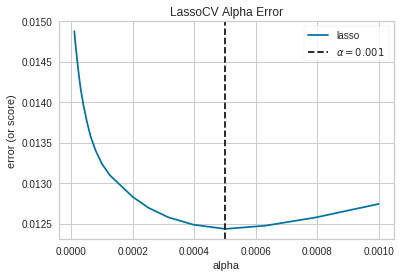

CPU times: user 30.4 s, sys: 484 ms, total: 30.9 s
Wall time: 5.48 s


In [65]:
%%time
# visualize lasso with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-5, -3, 21)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=20000, cv=kfolds))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()

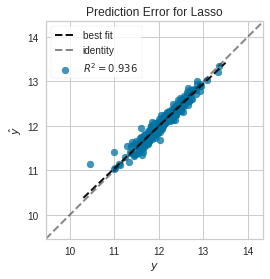

CPU times: user 1.33 s, sys: 24 ms, total: 1.36 s
Wall time: 226 ms


In [66]:
%%time
visualizer = PredictionError(Lasso(alpha=0.001))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test), y_test)
visualizer.poof()

In [67]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-4, -2, 11),
                              max_iter=100000,
                              cv=kfolds))

lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)

print()
scores = np.sqrt(-cross_val_score(lasso, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 17755.603312914656
Train R-squared 0.9457416743947904
Train MAE 11367.969967396442

Test RMSE 17079.188013331073
Test R-squared 0.9518142183549081
Test MAE 12343.088958638244
alpha 0.000630957344480193

CV Score 0.1060 (STD 0.0128)

CPU times: user 42.2 s, sys: 640 ms, total: 42.8 s
Wall time: 7.14 s


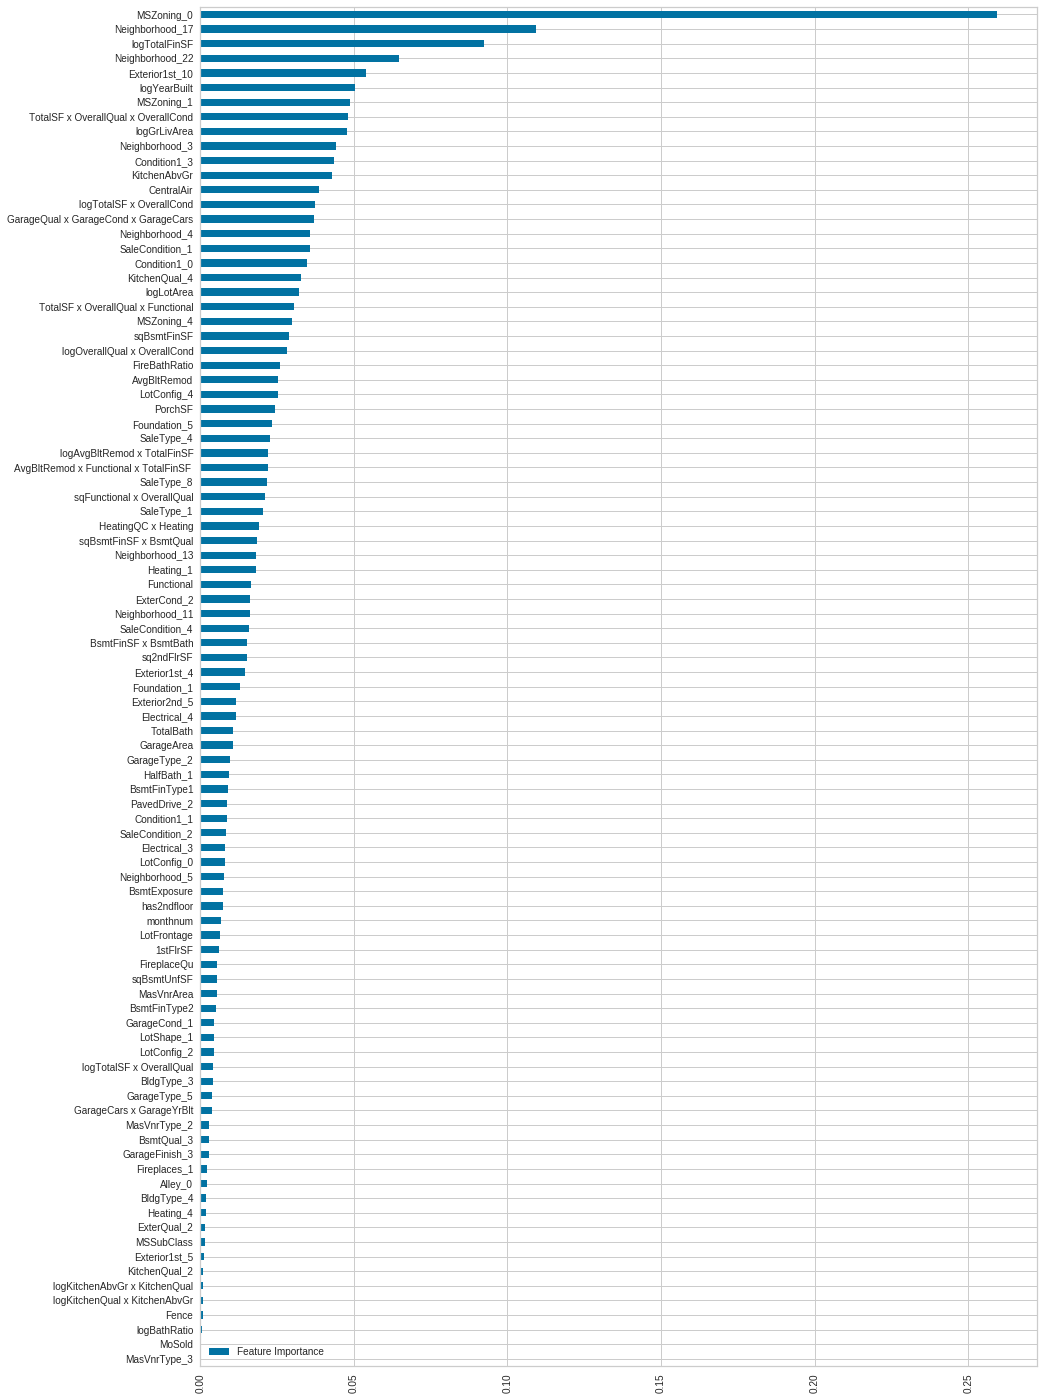

In [68]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

Train RMSE 17504.612259274294
Train R-squared 0.9472648105419748
Train MAE 11226.991761534011

Test RMSE 17152.356126454386
Test R-squared 0.9514004733010909
Test MAE 12472.002450531712


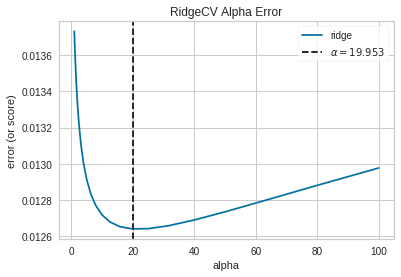

CPU times: user 720 ms, sys: 28 ms, total: 748 ms
Wall time: 165 ms


In [69]:
%%time
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()

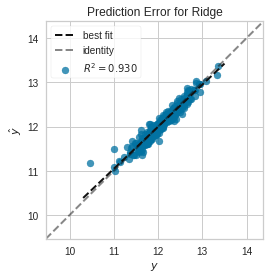

CPU times: user 692 ms, sys: 24 ms, total: 716 ms
Wall time: 121 ms


In [70]:
%%time
visualizer = PredictionError(Ridge(alpha=25.119))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [71]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)

print()
scores = np.sqrt(-cross_val_score(ridge, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 17691.434757908937
Train R-squared 0.9461331437147839
Train MAE 11344.639444067074

Test RMSE 17190.598128291138
Test R-squared 0.9511835217602971
Test MAE 12524.19323343837
alpha 25.11886431509581

CV Score 0.1074 (STD 0.0126)

CPU times: user 1min 23s, sys: 1.27 s, total: 1min 24s
Wall time: 14.2 s


In [72]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))
elasticnet.fit(X_train, y_train)

y_pred_train = elasticnet.predict(X_train)
y_pred_test = elasticnet.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)

print()
scores = np.sqrt(-cross_val_score(elasticnet, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


ElasticNetCV
Train RMSE 17517.607572797468
Train R-squared 0.9471864809342597
Train MAE 11231.100076423387

Test RMSE 17027.97710136548
Test R-squared 0.952102749435957
Test MAE 12274.827172280555
l1_ratio 0.8
alpha 0.000630957344480193

CV Score 0.1059 (STD 0.0129)

CPU times: user 15min 12s, sys: 13.2 s, total: 15min 25s
Wall time: 2min 53s


In [73]:
%%time
# tune KernelRidge
print("KernelRidge")

kralphas = np.logspace(-5,0,11)
kralpha = 0.03162277660168379

# linear, poly
# degree 1,2,3
coef0s = np.linspace(1,10, 19)
coef0=6

krdegrees = [1,2,3]
krdegree = 1

for i in [1]:

    kr = make_pipeline(use_transform(),
                       KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                      )
    print(kr)
    kr.fit(X_train, y_train)

    y_pred_train = kr.predict(X_train)
    y_pred_test = kr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()
    
    scores = np.sqrt(-cross_val_score(kr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()
    

KernelRidge
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kernelridge',
                 KernelRidge(alpha=0.03162277660168379, coef0=6, degree=1,
                             gamma=None, kernel='poly', kernel_params=None))],
         verbose=False)
Train RMSE 16916.384802807705
Train R-squared 0.9507495014191989
Train MAE 10925.753031704486

Test RMSE 17152.360358618633
Test R-squared 0.9514004493182394
Test MAE 12360.158205878117

CV Score 0.1069 (STD 0.0123)

CPU times: user 4.24 s, sys: 88 ms, total: 4.33 s
Wall time: 727 ms


In [74]:
%%time
# tune SVR
print("SVR")

Cs = np.logspace(0,2,5)
C = 3.1622776601683795

epsilons = np.logspace(-5,0,11)
epsilon = 0.03162277660168379

svrgammas = np.logspace(-5,0,11)
svrgamma = 0.001

for i in [1]:

    svr = make_pipeline(use_transform(),
                        SVR(kernel='rbf', 
        #                        degree=3, 
                            gamma=svrgamma,
        #                        coef0=0.0, 
        #                        tol=0.001, 
                            C=C, 
                            epsilon=epsilon, 
        #                        shrinking=True, 
        #                        cache_size=200, 
        #                        verbose=False, 
        #                        max_iter=-1))
                           ))
    print(svr)
    svr.fit(X_train, y_train)

    y_pred_train = svr.predict(X_train)
    y_pred_test = svr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)

    print()
    scores = np.sqrt(-cross_val_score(svr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()


SVR
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=3.1622776601683795, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.03162277660168379, gamma=0.001, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
Train RMSE 16419.29033138617
Train R-squared 0.9536014632463785
Train MAE 9743.602197592312

Test RMSE 17099.89169402017
Test R-squared 0.9516973243077299
Test MAE 11625.44669954702

CV Score 0.1059 (STD 0.0137)

CPU times: user 5.65 s, sys: 24 ms, total: 5.68 s
Wall time: 4.82 s


In [75]:
%%time
# tune Gradient Boost
print("Gradient Boost")
gbestimatorss = np.logspace(2,4,9)
gbestimators = 5623
gbdepth = 2
gblearnrate = 0.01

for i in range(1):
                           
    gb = GradientBoostingRegressor(n_estimators=int(gbestimators), 
                                   learning_rate=gblearnrate,
                                   max_depth=gbdepth, 
                                   max_features='sqrt',
                                   min_samples_leaf=16, 
                                   loss='huber', 
                                   subsample=0.8, 
                                   random_state=42)
    print(gb)
    gb.fit(X_train, y_train)
    
    y_pred_train = gb.predict(X_train)
    y_pred_test = gb.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()
    
    scores = np.sqrt(-cross_val_score(gb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()


Gradient Boost
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=16, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5623,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Train RMSE 14245.65452319596
Train R-squared 0.9650730762638707
Train MAE 8298.334363996612

Test RMSE 18032.26291367657
Test R-squared 0.9462863170798603
Test MAE 12322.301730935897

CV Score 0.1084 (STD 0.0151)

CPU times: user 1min 7s, sys: 116 ms, total: 1min 7s
Wall time: 1min 7s


In [ ]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - sophisticated decision tree model
# tuned sequentially
# no log1p

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 4

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:
 
        xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
        display(xgb)
    
        scores = np.sqrt(-cross_val_score(xgb, df_nodummies[predictors_nodummies], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
        
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()

In [ ]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - sophisticated decision tree model
# tuned sequentially
# no log1p

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 4

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:
 
        xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
        display(xgb)
    
        scores = np.sqrt(-cross_val_score(xgb, df_nodummies[predictors_nodummies], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
        
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()

In [83]:
xgb.fit(X_train_nd, y_train_nd.values.reshape(-1))
y_pred_train = xgb.predict(X_train_nd)
y_pred_test = xgb.predict(X_test_nd)
evaluate(y_train_nd, y_pred_train, y_test_nd, y_pred_test)

Train RMSE 2401.182611630245
Train R-squared 0.9990271398889695
Train MAE 1777.314531822344

Test RMSE 21541.320149679355
Test R-squared 0.9190315114620465
Test MAE 13394.753605769234


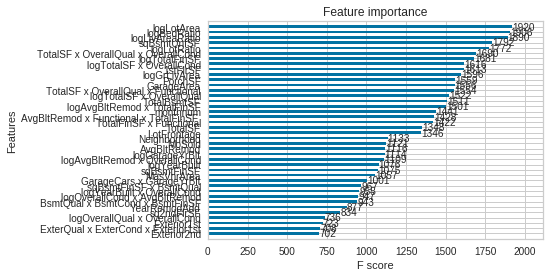

In [84]:
plot_importance(xgb, max_num_features=40, height=0.5)


In [ ]:
# get xgboost interactions, terms that show up in sam prediction trees
# alternatives to find interactions:
#   generate all interactions (product or ratio) and correlate vs. the residual
#   generate all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df_nodummies[predictors_nodummies]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


In [ ]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
# print high interaction pairs
# last row, col = bias term
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        if interaction_matrix[i,j] > threshold:
            print(predictors[i], predictors[j], interaction_matrix[i,j])

In [ ]:
%%time
# tune LightGBM
print("LightGBM")
#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df_nodummies[predictors_nodummies], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train_nd, y_train_nd.values.reshape(-1))
y_pred_train = lgbm.predict(X_train_nd)
y_pred_test = lgbm.predict(X_test_nd)
evaluate(y_train_nd, y_pred_train, y_test_nd, y_pred_test)


In [ ]:
# tune MLPRegressor
print("MLPregressor")

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(-1, 2, 7)
alphas = [3.162278]
alpha = 3.162278

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1,2,3]
nstartlayers = [128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print("Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train, y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass

In [ ]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [ ]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission

#outliers = [30, 88, 462, 631, 1322]
# big raw misses 
# outliers = [687, 801, 896, 1320, 631]

outliers = [687, 801, 896, 1320, 1449, 462, 631]
df=df.reset_index(drop=True)
df_nodummies=df_nodummies.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))

In [ ]:
print(df[predictors].shape)
df.drop(outliers, inplace=True)
df_nodummies.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
df_nodummies=df_nodummies.reset_index(drop=True)
print(df[predictors].shape)
df.tail()

In [ ]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [ ]:
%%time

models = {
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
    'gb'        : gb,
}

for i, m in enumerate(mlpmodels):
    models["mlp%d" % i] = m
    
for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

In [ ]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0', 'mlp1', 'mlp2'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


### 6. Stack and Blend

In [ ]:
df2 = pd.DataFrame(use_transform().fit_transform(df[predictors]), columns=predictors)
df2 = pd.concat((df2, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1778

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    display(stack_xgb)

    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]], 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    stack_xgb.fit(xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]], 
                  xval_df['log_y'])
    
    full_train_df['stack_xgb'] = stack_xgb.predict(xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]])
    print("%s CV Score %.04f" % ('stack_xgb', cvscores['stack_xgb']))


In [ ]:
df2 = pd.DataFrame(use_transform().fit_transform(df[predictors]), columns=predictors)
df2 = pd.concat((df2, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)

stack_lasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=False)
                           

display(stack_lasso)

xval_df['stack_lasso'] = cross_val_predict(stack_lasso, 
                                     xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]], 
                                     xval_df['log_y'], 
                                     cv=kfolds)
cvscores['stack_lasso'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_lasso']))
stack_lasso.fit(xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]], 
              df[response])
full_train_df['stack_lasso'] = stack_lasso.predict(xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]])
print("%s CV Score %.04f" % ('stack_lasso', cvscores['stack_lasso']))


In [ ]:
# stack models
# with use_features_in_secondary we probably need to scale 

boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
boost_blend.fit(df[predictors], df[response])

linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
                                           ('ridge', ridge), 
                                           ('elasticnet', elasticnet), 
                                           ('kr', kr)])
linear_blend.fit(df[predictors], df[response])

mlp_blend =    VotingRegressor(estimators=[('mlp0', mlpmodels[0]), 
                                           ('mlp1', mlpmodels[1]), 
                                           ('mlp2', mlpmodels[2])])
mlp_blend.fit(df[predictors], df[response])

In [ ]:
# this stack is very slow and marginal improvement over stacking pre-calculated blends
stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[boost_blend, linear_blend, mlp_blend, gb, svr, ],
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

In [ ]:
%%time
print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors].values)
print(datetime.datetime.now(), "full train finished")


In [ ]:
blendpredictors = ['stack', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
full_train_corr = full_train_df[['stack', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
#%%time
# blend stacked model with individual models using a weighted average.
# first equal-weight average the similar models (VotingRegressor): linear vs. boosting
# then fit a linear model to the resulting models
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

# xgb and lgbm correlation > .998
# xval_df['boostblend'] = xval_df[['xgb', 'lgbm']].mean(axis=1)
# full_train_df['boostblend'] = full_train_df[['xgb', 'lgbm']].mean(axis=1)

# linear models correlation > .998
# xval_df['linearblend'] = xval_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)
# full_train_df['linearblend'] = full_train_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)

# 3 ML models
# xval_df['mlpblend'] = xval_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)
# full_train_df['mlpblend'] = full_train_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


In [ ]:
#blend only

blendpredictors2 = [ 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso2= LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendlasso2.fit(xval_df[blendpredictors2],
                xval_df['log_y'])

xval_df['rawblend']=blendlasso2.predict(xval_df[blendpredictors2])
cvscores['rawblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['rawblend']))
print("rawblend crossval score %.6f" % cvscores['rawblend'])

full_train_df['rawblend']= blendlasso2.predict(full_train_df[blendpredictors2])
print("rawblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                    full_train_df['rawblend'])))

print('coefs', dict(zip(blendpredictors2,
                        list(blendlasso2.coef_))))
print('coefs adjusted to sum to 1', blendlasso2.coef_/np.sum(blendlasso2.coef_))
print('intercept', blendlasso2.intercept_)
print('sum', np.sum(blendlasso2.coef_))
print('alpha', blendlasso2.alpha_ )

In [ ]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


In [ ]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


In [ ]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


In [ ]:
res = stats.probplot(residual['error_log'], plot=plt);

In [ ]:
sns.regplot(x="log_y", y="error_log", data=residual).set_title('Error v. Actual');


In [ ]:
sns.regplot(x="stackblend", y="error_log", data=residual).set_title('Error v. Predicted');

In [ ]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


### 7. Run on test set, export CSV for submission

In [ ]:
submit_df = pd.DataFrame({'stack' : stack.predict(df_test[predictors]),
                          'boost_blend' : boost_blend.predict(df_test[predictors]),
                          'gb' : gb.predict(df_test[predictors]),
                          'mlp_blend' : mlp_blend.predict(df_test[predictors]),
                          'svr' : svr.predict(df_test[predictors]),
                          'linear_blend' : linear_blend.predict(df_test[predictors]),
                          'stackblend': stack.predict(df_test[predictors])
                         })

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.0 * submit_df['stack'] + \
     0.17206565        * submit_df['boost_blend'] + \
     0.03032861 * submit_df['gb']  + \
     0.2205657 * submit_df['mlp_blend'] +\
     0.35787068 * submit_df['svr'] + \
     0.21916937 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.10       * submit_df['stack'] + \
     0.10       * submit_df['boost_blend'] + \
     0.05       * submit_df['gb'] + \
     0.25       * submit_df['mlp_blend'] +\
     0.25       * submit_df['svr'] + \
     0.25       * submit_df['linear_blend'] 

submit_df['rawblend'] = \
     0.20       * submit_df['boost_blend'] + \
     0.05       * submit_df['gb'] + \
     0.25       * submit_df['mlp_blend'] +\
     0.25       * submit_df['svr'] + \
     0.25       * submit_df['linear_blend'] 

submit_df


In [ ]:
submit_df =np.expm1(submit_df)
submit_df.describe()


In [ ]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['rawblend']}).to_csv('rawblend.csv', index=False)
